**Import Libraries**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from datetime import date
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import gc

import warnings
warnings.filterwarnings('ignore')

**Import Data**

In [2]:
data = pd.read_csv('./data/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [3]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')

In [4]:
data = data.set_index(pd.DatetimeIndex(data['date_time']))

In [5]:
ts = data.traffic_volume['2017-09-29':'2018-09-29']

In [6]:
ts.head()

date_time
2017-09-29 00:00:00    751
2017-09-29 01:00:00    432
2017-09-29 02:00:00    310
2017-09-29 03:00:00    348
2017-09-29 04:00:00    860
Name: traffic_volume, dtype: int64

**Train/test Split**

In [7]:
split_date = '2018-08-30'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

**Stationnarity**

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(168).mean()
    rolstd = timeseries.rolling(168).std()

    #Plot rolling statistics:
    plt.figure(figsize=(30,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

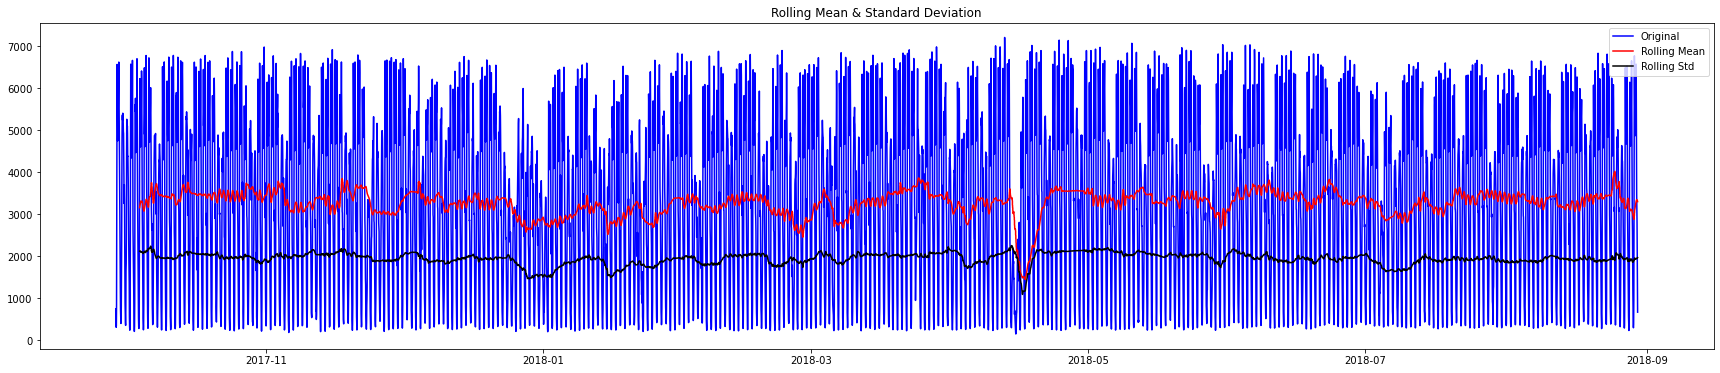

Results of Dickey-Fuller Test:
Test Statistic                -1.548486e+01
p-value                        2.528511e-28
#Lags Used                     3.300000e+01
Number of Observations Used    9.624000e+03
Critical Value (1%)           -3.431030e+00
Critical Value (5%)           -2.861840e+00
Critical Value (10%)          -2.566930e+00
dtype: float64


In [9]:
test_stationarity(ts_train)

**Building a model**

In [10]:
# ACF and PACF plots
lag = 168
lag_pacf = pacf(ts_train, nlags=lag, method='ols')
lag_acf = acf(ts_train, nlags=lag)

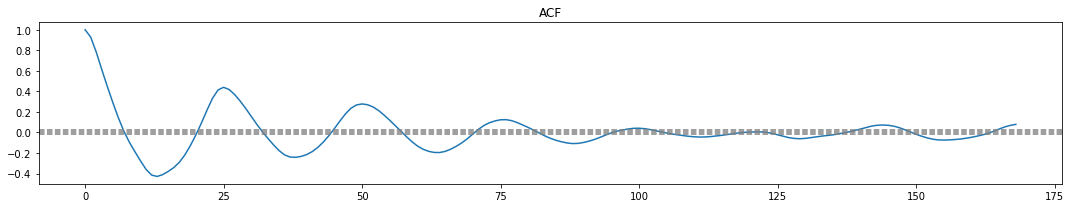

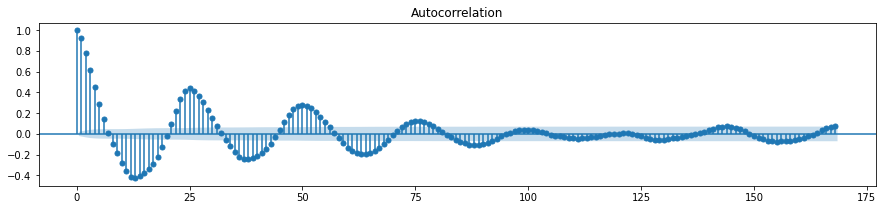

In [11]:
#Plot ACF: 
plt.figure(figsize=(15,3))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_acf(ts_train, ax=plt.gca(),lags=lag)
plt.show()

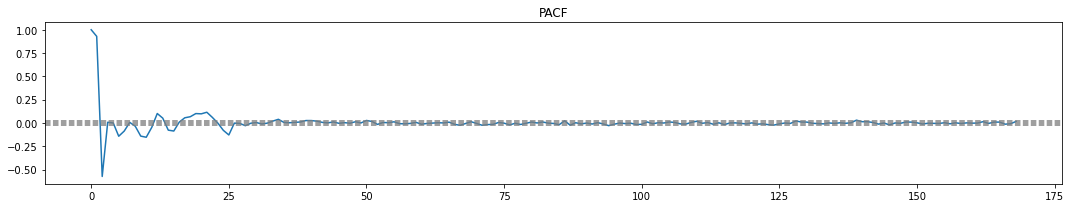

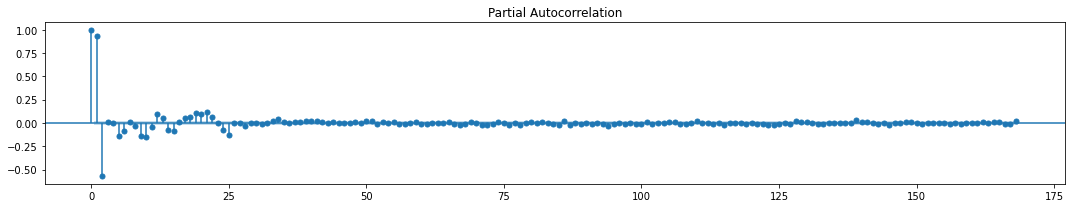

In [12]:
#Plot PACF:
plt.figure(figsize=(15,3))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,3))
plot_pacf(ts_train, ax=plt.gca(), lags=lag)
plt.tight_layout()
plt.show()

In [13]:
p=1
q=7
d=0

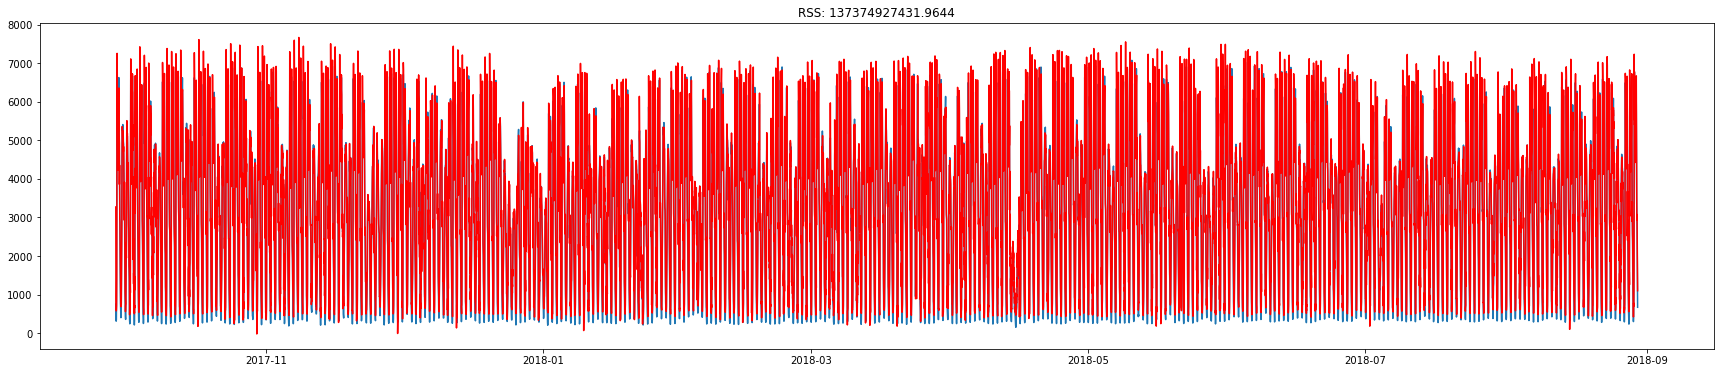

In [14]:
# ARIMA
model = ARIMA(ts_train, order=(p, d, q))  
results_ARIMA = model.fit(disp=1)
plt.figure(figsize=(30,6))
plt.plot(ts_train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show()

In [15]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                 9658
Model:                     ARMA(1, 7)   Log Likelihood              -75380.274
Method:                       css-mle   S.D. of innovations            593.399
Date:                Mon, 07 Mar 2022   AIC                         150780.548
Time:                        16:05:03   BIC                         150852.303
Sample:                             0   HQIC                        150804.878
                                                                              
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3271.8814     54.763     59.746      0.000    3164.548    3379.214
ar.L1.traffic_volume     0.3852      0.044      8.853      0.000       0.300       0.470
ma.L1.traffic_volume     1.0799      0.042     25.523      0.000       0.997       1.163
ma.L2.traffic_volume     1.0354      0.063     16.507      0.000       0.912       1.158
ma.L3.traffic_volume     0.8270      0.071     11.581      0.000       0.687       0.967
ma.L4.traffic_volume     0.6510      0.066      9.921      0.000       0.522       0.780
ma.L5.traffic_volume     0.5081      0.051     10.003      0.000       0.409       0.608
ma.L6.traffic_volume     0.3355      0.033     10.254      0.000       0.271       0.400
ma.L7.traffic_volume     0.1409      0.017      8.509      0.000       0.108       0.173
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.5961           +0.0000j            2.5961            0.0000
MA.1            0.7582           -1.0095j            1.2625           -0.1475
MA.2            0.7582           +1.0095j            1.2625            0.1475
MA.3           -0.2068           -1.2609j            1.2778           -0.2759
MA.4           -0.2068           +1.2609j            1.2778            0.2759
MA.5           -1.0300           -0.9243j            1.3839           -0.3836
MA.6           -1.0300           +0.9243j            1.3839            0.3836
MA.7           -1.4240           -0.0000j            1.4240           -0.5000
-----------------------------------------------------------------------------
"""

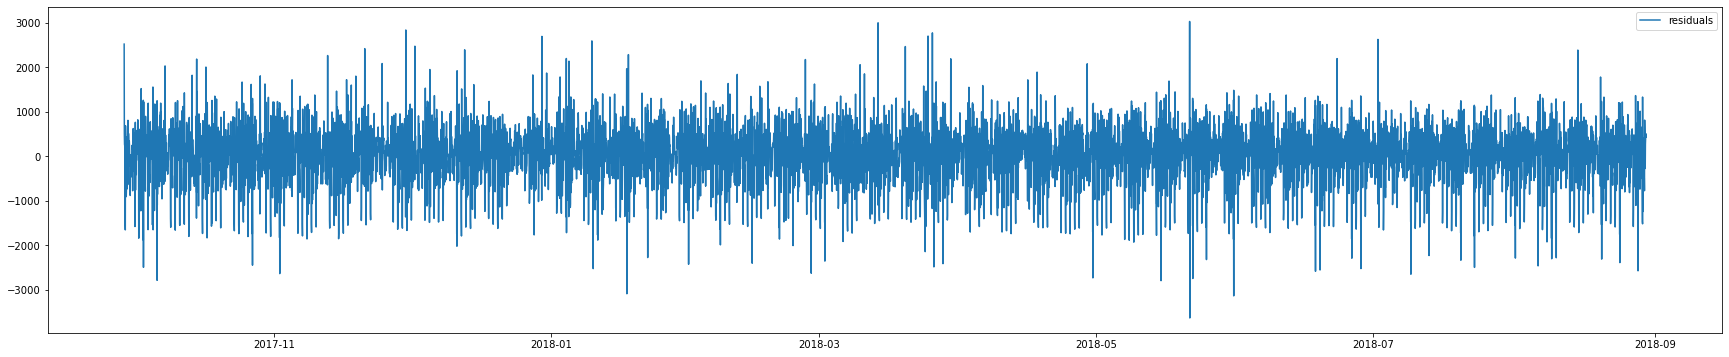

In [16]:
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ['traffic_volume']
x = x.traffic_volume - ts_train
plt.figure(figsize=(30,6))
plt.plot(x, label='residuals')
plt.legend(loc='best')
plt.show()

## Test ARIMA on testset

In [17]:
def StartARIMAForecasting(Actual, p, d, q):
	model = ARIMA(Actual, order=(p, d, q))
	model_fit = model.fit(disp=0)
	prediction = model_fit.forecast()[0]
	return prediction

In [18]:
#new arrays to store actual and predictions
Actual = [x for x in ts_train]
Predictions = list()

#in a for loop, predict values using ARIMA model
for timepoint in range(len(ts_test)):
	ActualValue =  ts_test[timepoint]
	#forcast value
	Prediction = StartARIMAForecasting(Actual, 3,1,0)    
	print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
	#add it in the list
	Predictions.append(Prediction)
	Actual.append(ActualValue)  
 
predictions=pd.DataFrame(Predictions).set_index(ts_test.index)

Actual=456.000000, Predicted=451.471047
Actual=326.000000, Predicted=457.903029
Actual=388.000000, Predicted=327.377443
Actual=388.000000, Predicted=453.416653
Actual=1008.000000, Predicted=397.433606
Actual=1008.000000, Predicted=1354.244710
Actual=3070.000000, Predicted=969.015629
Actual=5886.000000, Predicted=4178.446079
Actual=6466.000000, Predicted=7359.556127
Actual=6466.000000, Predicted=6406.672128
Actual=5995.000000, Predicted=6141.210969
Actual=5467.000000, Predicted=5667.862757
Actual=4911.000000, Predicted=5196.665933
Actual=5095.000000, Predicted=4676.585183
Actual=5308.000000, Predicted=5289.331459
Actual=5213.000000, Predicted=5474.864424
Actual=5680.000000, Predicted=5126.858820
Actual=6238.000000, Predicted=5930.203339
Actual=6453.000000, Predicted=6536.012386
Actual=5775.000000, Predicted=6492.472882
Actual=4531.000000, Predicted=5318.652789
Actual=3884.000000, Predicted=3844.151277
Actual=3332.000000, Predicted=3664.484494
Actual=3049.000000, Predicted=3186.623446
Ac

Actual=4785.000000, Predicted=4853.388377
Actual=5436.000000, Predicted=4777.318207
Actual=5436.000000, Predicted=5790.645268
Actual=5667.000000, Predicted=5397.534416
Actual=5667.000000, Predicted=5731.563693
Actual=5494.000000, Predicted=5653.563173
Actual=5494.000000, Predicted=5373.024457
Actual=5494.000000, Predicted=5504.574745
Actual=4383.000000, Predicted=5511.893875
Actual=4383.000000, Predicted=3755.467229
Actual=4383.000000, Predicted=4449.205693
Actual=4383.000000, Predicted=4496.272008
Actual=3017.000000, Predicted=4383.219483
Actual=3017.000000, Predicted=2245.554088
Actual=3017.000000, Predicted=3098.047785
Actual=2385.000000, Predicted=3156.159497
Actual=2385.000000, Predicted=2028.274687
Actual=2385.000000, Predicted=2422.586802
Actual=2105.000000, Predicted=2449.255812
Actual=2105.000000, Predicted=1947.010493
Actual=2105.000000, Predicted=2121.695311
Actual=1351.000000, Predicted=2133.490869
Actual=1351.000000, Predicted=925.376722
Actual=1351.000000, Predicted=1395.

Actual=4875.000000, Predicted=4626.099003
Actual=4922.000000, Predicted=4887.163280
Actual=5636.000000, Predicted=4976.687147
Actual=6601.000000, Predicted=6020.118041
Actual=5859.000000, Predicted=7100.078738
Actual=4372.000000, Predicted=5315.288022
Actual=3427.000000, Predicted=3475.675556
Actual=3114.000000, Predicted=3054.857916
Actual=2501.000000, Predicted=3145.679032
Actual=1860.000000, Predicted=2272.566099
Actual=2682.000000, Predicted=1565.922943
Actual=750.000000, Predicted=3243.256180
Actual=344.000000, Predicted=-311.888113
Actual=314.000000, Predicted=133.658370
Actual=371.000000, Predicted=521.194805
Actual=937.000000, Predicted=447.039086
Actual=3085.000000, Predicted=1254.600597
Actual=5908.000000, Predicted=4254.200262
Actual=6677.000000, Predicted=7319.426535
Actual=6297.000000, Predicted=6731.639966
Actual=5551.000000, Predicted=5746.502595
Actual=5551.000000, Predicted=5072.262081
Actual=4499.000000, Predicted=5631.679900
Actual=4499.000000, Predicted=3986.492522


Actual=4527.000000, Predicted=4559.330399
Actual=4593.000000, Predicted=4588.738553
Actual=4725.000000, Predicted=4630.188375
Actual=4737.000000, Predicted=4795.605422
Actual=4931.000000, Predicted=4730.029470
Actual=5623.000000, Predicted=5025.625117
Actual=6623.000000, Predicted=5999.177855
Actual=5916.000000, Predicted=7126.199520
Actual=4423.000000, Predicted=5395.003531
Actual=4423.000000, Predicted=3521.907522
Actual=3309.000000, Predicted=4577.244063
Actual=3309.000000, Predicted=2839.212988
Actual=2805.000000, Predicted=3369.062644
Actual=2400.000000, Predicted=2638.081287
Actual=2631.000000, Predicted=2200.475731
Actual=2631.000000, Predicted=2834.104615
Actual=1501.000000, Predicted=2660.479582
Actual=617.000000, Predicted=844.848762
Actual=617.000000, Predicted=183.045506
Actual=401.000000, Predicted=780.982020
Actual=401.000000, Predicted=371.027099
Actual=282.000000, Predicted=412.620426
Actual=282.000000, Predicted=237.595733
Actual=358.000000, Predicted=288.384585
Actual

Actual=339.000000, Predicted=245.920212
Actual=514.000000, Predicted=374.687024
Actual=910.000000, Predicted=634.681291
Actual=1402.000000, Predicted=1118.245461
Actual=2203.000000, Predicted=1636.824869
Actual=3562.000000, Predicted=2581.512354
Actual=4594.000000, Predicted=4224.325181
Actual=4252.000000, Predicted=5017.250064
Actual=3945.000000, Predicted=3874.847872
Actual=4107.000000, Predicted=3687.399252
Actual=4091.000000, Predicted=4246.403754
Actual=4195.000000, Predicted=4105.571546
Actual=4413.000000, Predicted=4237.024447
Actual=4117.000000, Predicted=4530.234998
Actual=3997.000000, Predicted=3932.416347
Actual=3516.000000, Predicted=3923.212671
Actual=2846.000000, Predicted=3286.220570
Actual=2346.000000, Predicted=2511.468705
Actual=1635.000000, Predicted=2151.220906
Actual=934.000000, Predicted=1334.384289
Actual=509.000000, Predicted=631.875378
Actual=344.000000, Predicted=380.300612
Actual=219.000000, Predicted=344.537108
Actual=328.000000, Predicted=200.984297
Actual=

In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
#Calculate Model error
'''
print('Train Mean Absolute Error:', mean_absolute_error(ts_train, ts_train_fcst[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_train, ts_train_fcst[:,0])))
print('Train Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_train, ts_train_fcst[:,0]))
'''
print('Test Mean Absolute Error:', mean_absolute_error(ts_test, predictions))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test, predictions)))
print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(ts_test, predictions[0]))

Test Mean Absolute Error: 429.51626451272654
Test Root Mean Squared Error: 644.0856329677813
Test Mean Absolute percentage Error: 19.077074806866634


KeyError: (slice(None, None, None), None)

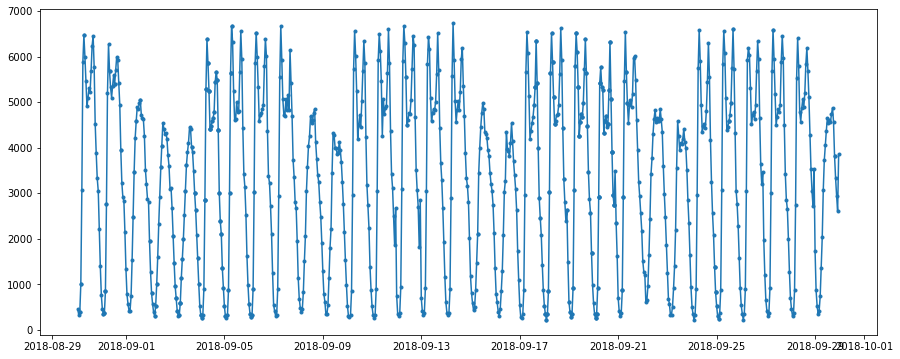

In [21]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions), 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

KeyError: (slice(None, None, None), None)

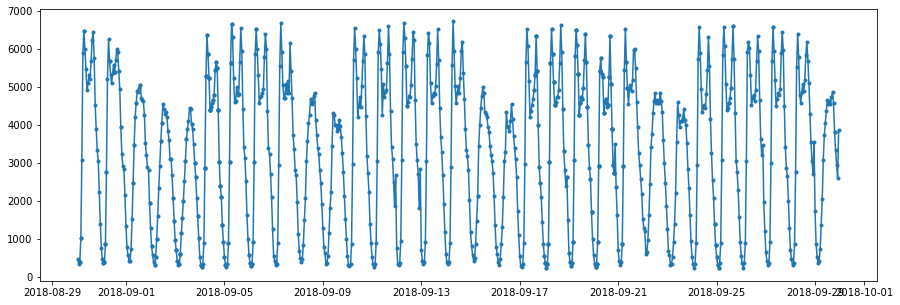

In [22]:
# zoom on lastest week
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test), marker='.', label="actual")
plt.plot(ts_test.index, pd.DataFrame(Predictions), 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,22), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 7000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')